# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib

import itertools

plt.style.use("ggplot")

from collections import Counter

Seed set to 8


--------
### 実験設定

In [2]:
N_CLUSTERS = 3  # クラスタ数
N_FEATURES_TO_SELECT = 17  # 選択される最大の特徴量数

SAMPLE_SIZE = 1000  # 標本サイズ
DATA_SIZE = 100000  # データサイズ(df2)
N_TRIALS = 100  # 試行回数（標本平均を求める回数）
# N_EXPERIMENT = 1  # 分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード
ALLOCATION_METHODS = [
    "ProportionalAllocation",
    "PostStratification",
    "OptimalAllocation",
]  # "RandomAllocation"はいれない
CLUSTERING_METHOD = "kmeans"  # "gmm" or "kmeans"

SELECTING_FEATURES = (
    "all_features"  # "all_features" or "not_all_features" #特徴量をすべて選ぶかどうか
)

-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(df, obj)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

-------------
### 提案手法でクラスタリング

##### Allocation_in_Wrapper Class
とりあえずproportional でやってみる  
・データによってはクラスタ数=3と指定した場合も2になることもある  
⇒ この場合はstopする

In [6]:
class Allocation_in_Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        n_features_to_select: int,
        n_clusters: int,
        clustering_method: str = "kmeans",
        allocation_methods: list[str] = ["ProportionalAllocation"],
        sample_size: int = 10,
        n_trials: int = 100,
        m_value=2,
        M: Optional[NDArray] = None,
        random_state: int = 0,
        selecting_features: str = "all_features",
    ):
        self.n_features_to_select = n_features_to_select
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.allocation_methods = allocation_methods
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.m_value = m_value
        self.M = M
        self.random_state = random_state
        self.selecting_features = selecting_features

    def fss(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> "Allocation_in_Wrapper":  ###これ自体は多分あってる
        X, y = check_X_y(X, y)
        n_features = X.shape[1]  # 総特徴量数
        self.selected_features_dict = {}
        self.final_cluster_assignments_dict = {}
        self.features_score_dict = {}

        # ランダムの分散を計算
        self.random_allocation_std = self.cauculate_random_std(X, y)
        print(self.random_allocation_std)

        # 特徴量選択
        for allocation_method in self.allocation_methods:
            print("[", allocation_method, "]")

            features_score_dict = {}  # 確認用

            # 選ばれた特徴量と残っている特徴量の初期化
            current_features = []
            remaining_features = list(range(n_features))
            if self.selecting_features == "not_all_features":
                best_score = -np.inf

            while len(current_features) < self.n_features_to_select:
                if self.selecting_features == "all_features":
                    best_score = -np.inf
                best_feature = None  # 選ぶ特徴量の初期化

                for feature in remaining_features:
                    temp_features = tuple(
                        current_features + [feature]
                    )  # 特徴量をひとつ加え、score計算    ###########ここまでok
                    print("temp_features", temp_features)
                    score = self.crit(X[:, temp_features], y, allocation_method)
                    print("score", score)
                    if score > best_score:
                        print("特徴量更新")
                        best_score = score
                        best_feature = feature

                if best_feature is not None:
                    current_features.append(
                        best_feature
                    )  # best feature をcurrent features に追加
                    num_of_features = len(current_features)
                    self.y_hat_df_random = self.cauculate_random_std(X, y)
                    print(
                        "num_of_features:",
                        num_of_features,
                        "current_features:",
                        current_features,
                        ", score:",
                        best_score,
                    )

                    features_score_dict[str(num_of_features)] = best_score  # 確認用

                    remaining_features.remove(
                        best_feature
                    )  # best feature をremaining features から取り除く
                    self.selected_features_ = current_features
                else:
                    break

                # 選ばれた特徴量サブセットでクラスタリング
                final_features = X[:, self.selected_features_]
                if self.clustering_method == "gmm":
                    final_model_ = GaussianMixture(
                        n_components=self.n_clusters,
                        random_state=self.random_state,
                        init_params="kmeans",
                    )
                elif self.clustering_method == "kmeans":
                    final_model_ = KMeans(
                        n_clusters=self.n_clusters, random_state=self.random_state
                    )
                else:
                    raise ValueError(
                        f"Unknown clustering method: {self.clustering_method}"
                    )

                final_model_.fit(final_features)
                self.final_cluster_assignments_dict[allocation_method] = (
                    final_model_.predict(final_features)
                )
                self.features_score_dict[allocation_method] = (
                    features_score_dict  # 確認用
                )

                self.selected_features_dict[allocation_method] = self.selected_features_

        return self

    def crit(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:  ##これ自体は大丈夫
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            em = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
            em.fit(X)
            self.N_cluster_label = em.predict(X)
            self.N_cluster_size = np.bincount(
                self.N_cluster_label, minlength=self.n_clusters
            )

        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            kmeans = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
            kmeans.fit(X)
            self.N_cluster_label = kmeans.predict(X)
            self.N_cluster_size = np.bincount(
                self.N_cluster_label, minlength=self.n_clusters
            )

        if (
            0 in self.N_cluster_size
        ):  # 母集団のクラスタ数が十分でない場合score=0 にする(あとでかえる)
            score = 0
        else:  ###################
            error_variance_reduction_rate = self.cauculate_reduction_rate(
                X, y, allocation_method
            )
            score = error_variance_reduction_rate

        return score

    def cauculate_reduction_rate(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:  ######これ自体は大丈夫
        # 各戦略の標本数に基づいて目的変数の平均を推定
        y_hats = []
        for random_state in range(N_TRIALS):
            if allocation_method == "PostStratification":
                y_hat = self.estimate_y_mean_post(X, y)
            else:
                y_hat = self.estimate_y_mean_other(X, y, allocation_method)
            y_hats.append(
                {
                    "policy": allocation_method,
                    "y_hat": y_hat,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        non_random_allocation_std = y_hat_df["error"].var()
        # 削減率
        reduction_rate = (
            1 - non_random_allocation_std / self.random_allocation_std
        ) * 100

        return reduction_rate

    def cauculate_random_std(self, X, y):  # 多分あってる
        y_hats = []
        for random_state in range(self.n_trials):
            sample = np.random.choice(y, self.sample_size, replace=False)
            y_hat_random = sample.mean()
            y_hats.append(
                {
                    "policy": "RandomAllocation",
                    "y_hat": y_hat_random,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = y_hat_df["y_hat"] - y.mean()
        random_allocation_std = y_hat_df["error"].var()
        return random_allocation_std

    def estimate_y_mean_post(self, X, y) -> float:  # あってそう
        n_cluster_size = np.array([self.sample_size])

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        indices = np.arange(self.N_cluster_size.sum())
        y_array = np.array(y.tolist())
        n_indices = np.random.choice(indices, n_cluster_size[0], replace=False)
        n_label = np.array([self.N_cluster_label[i] for i in n_indices])
        n_new_labels = np.unique(n_label)
        for h in n_new_labels:
            index = np.where(n_label == h)[0]
            sample = y_array[n_indices[index]]
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
        return y_hat

    def estimate_y_mean_other(self, X, y, allocation_method) -> float:  # 多分あっている
        if allocation_method == "ProportionalAllocation":
            n_cluster_size = self.ProportionalAllocation(X, y)
        if allocation_method == "OptimalAllocation":
            n_cluster_size = self.OptimalAllocation(X, y)

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        for h in range(n_cluster_size.shape[0]):
            if n_cluster_size[h] != 0:
                y_cluster = y[self.N_cluster_label == h]

                sample: NDArray = np.random.choice(
                    y_cluster, n_cluster_size[h], replace=False
                )
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]
        return y_hat

    def get_feature_index_out(self) -> dict[NDArray]:
        return self.selected_features_dict  # 選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> dict[NDArray]:
        return self.final_cluster_assignments_dict  # 最終的なクラスタリング結果

    def get_features_score(self) -> dict[dict]:
        return self.features_score_dict

    def ProportionalAllocation(self, X, y) -> NDArray:  # あってそう
        n_cluster_size: NDArray = np.round(
            self.N_cluster_size / self.N_cluster_size.sum() * self.sample_size
        ).astype(int)

        if n_cluster_size.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n_cluster_size[np.argmax(n_cluster_size)] -= (
                n_cluster_size.sum() - self.sample_size
            )
        if n_cluster_size.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n_cluster_size[np.argmax(n_cluster_size)] += (
                -n_cluster_size.sum() + self.sample_size
            )

        return n_cluster_size

    def OptimalAllocation(self, X, y) -> NDArray:  # たぶんあってる
        self.m = np.full(self.n_clusters, self.m_value)
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array(
            [np.var(y[self.N_cluster_label == h]) for h in range(self.n_clusters)]
        )
        d = (self.N_cluster_size**2) * S

        n_cluster_size = self.m.copy()  # 初期値

        M = self.M.copy() if self.M is not None else self.N_cluster_size.copy()
        I = np.arange(self.n_clusters)  # noqa #クラスタのインデックス
        while (n_cluster_size.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.n_clusters)
            delta[I] = (d / (n_cluster_size + 1) - d / n_cluster_size)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n_cluster_size[h_star] + 1 <= M[h_star]:
                n_cluster_size[h_star] = n_cluster_size[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        # 制約チェック
        assert (
            n_cluster_size.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n_cluster_size >= self.m
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n_cluster_size <= self.M
            ), "Maximum sample size constraint is not satisfied"

        return n_cluster_size

17617.555138784952
[ ProportionalAllocation ]
temp_features (0,)


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


score -22.539444484279446
特徴量更新
temp_features (1,)
score -31.956445810278787
temp_features (2,)
score 0
特徴量更新
temp_features (3,)


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


score -10.887607347750428
temp_features (4,)
score -49.73613590221253
temp_features (5,)
score -30.51966105456112
temp_features (6,)
score -49.14896398041604
temp_features (7,)
score -10.621621614905052
temp_features (8,)
score -22.597798268126667
temp_features (9,)
score -39.437801112072755
temp_features (10,)
score -32.31736456547956
temp_features (11,)
score -62.49272262093704
temp_features (12,)
score -37.19323958652283
temp_features (13,)
score -55.14504609184661
temp_features (14,)
score -26.74404848726988
temp_features (15,)
score -22.49464052317869
temp_features (16,)
score -16.942358869098562
num_of_features: 1 current_features: [2] , score: 0
temp_features (2, 0)


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


score -38.40863534907453
特徴量更新
temp_features (2, 1)
score -16.11444078329751
特徴量更新
temp_features (2, 3)
score -1.0665722334473493
特徴量更新
temp_features (2, 4)
score 4.542976406428267
特徴量更新
temp_features (2, 5)
score 14.723835129844332
特徴量更新
temp_features (2, 6)
score -5.833722511038464
temp_features (2, 7)
score 3.5140265936388637
temp_features (2, 8)
score -37.877057700074786
temp_features (2, 9)
score -15.480614396653113
temp_features (2, 10)
score -40.762524250517984
temp_features (2, 11)
score -45.43427529732402
temp_features (2, 12)
score -6.907929299714977
temp_features (2, 13)
score -15.238314095747452
temp_features (2, 14)
score -13.502782747810826
temp_features (2, 15)
score -52.009468434861006
temp_features (2, 16)
score -27.664430971034726
num_of_features: 2 current_features: [2, 5] , score: 14.723835129844332
temp_features (2, 5, 0)
score -5.724386892894695
特徴量更新
temp_features (2, 5, 1)
score -40.212271087525586
temp_features (2, 5, 3)
score -15.881035615251871
temp_features 

c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


score -1.2065546604139943
temp_features (4,)
score -12.87013224206044
temp_features (5,)
score -25.932369412035893
temp_features (6,)
score -9.940801406789014
temp_features (7,)
score -8.980962524565284
temp_features (8,)
score -32.11095767400576
temp_features (9,)
score -15.030322515668448
temp_features (10,)
score -14.773304453340842
temp_features (11,)
score -64.11504760534679
temp_features (12,)
score -1.2323335033534333
temp_features (13,)
score 8.312247708832142
特徴量更新
temp_features (14,)
score -1.9180562721787586
temp_features (15,)
score -4.222987877043249
temp_features (16,)
score 1.957666910842959
num_of_features: 1 current_features: [13] , score: 8.312247708832142
temp_features (13, 0)
score -40.648976043961206
特徴量更新
temp_features (13, 1)
score 5.8180994040486045
特徴量更新
temp_features (13, 2)
score -42.76626774152339
temp_features (13, 3)
score -28.608207911654947
temp_features (13, 4)
score -19.46891352004958
temp_features (13, 5)
score -43.85194476775298
temp_features (13, 6)

c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


score -24.818878408680067
temp_features (4,)
score -34.40107646918775
temp_features (5,)
score 15.495717571997536
特徴量更新
temp_features (6,)
score -16.901408268585683
temp_features (7,)
score -47.09347770173969
temp_features (8,)
score -9.905177488304616
temp_features (9,)
score -18.972335902823435
temp_features (10,)
score -46.54892103169963
temp_features (11,)
score -30.69931464083131
temp_features (12,)
score -26.60521640938174
temp_features (13,)
score -9.886145240112665
temp_features (14,)
score -9.484572393088131
temp_features (15,)
score -33.92730102614516
temp_features (16,)
score -5.922019631455022
num_of_features: 1 current_features: [5] , score: 15.495717571997536
temp_features (5, 0)
score -4.831786976083174
特徴量更新
temp_features (5, 1)
score -2.857897589315317
特徴量更新
temp_features (5, 2)
score 1.6405835013622805
特徴量更新
temp_features (5, 3)
score 9.727710994109017
特徴量更新
temp_features (5, 4)
score -4.8981012559075054
temp_features (5, 6)
score -47.7183513394964
temp_features (5, 7

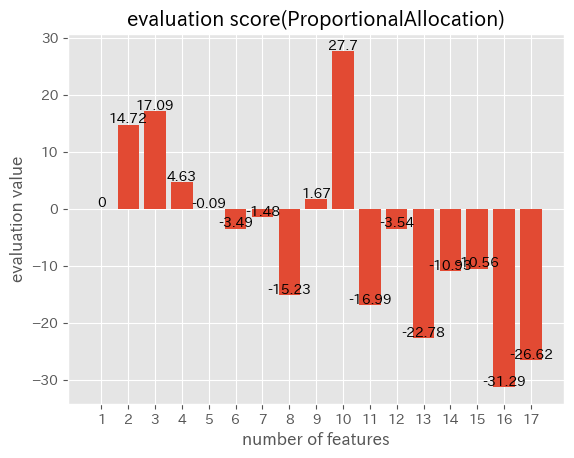

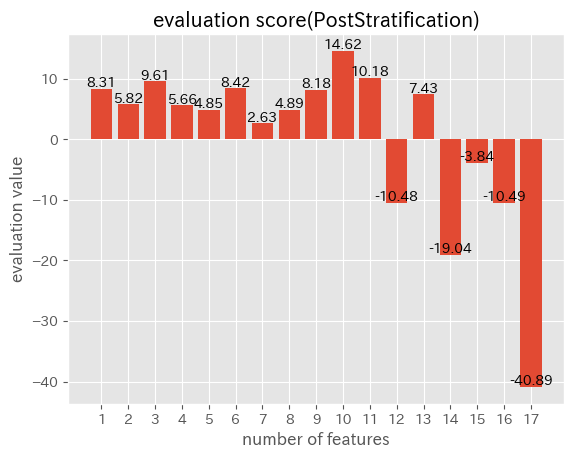

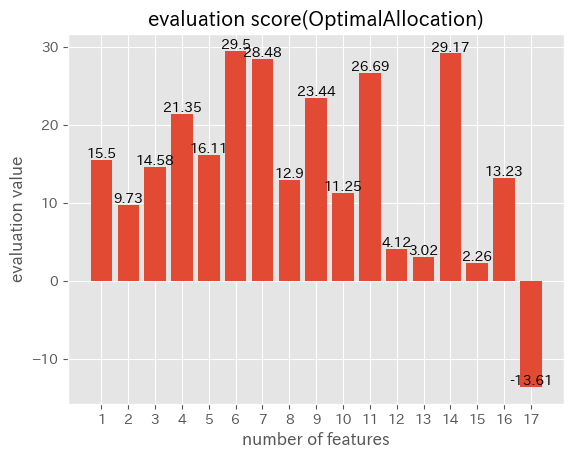

In [7]:
ins = Allocation_in_Wrapper(
    n_features_to_select=N_FEATURES_TO_SELECT,
    n_clusters=N_CLUSTERS,
    clustering_method=CLUSTERING_METHOD,
    allocation_methods=ALLOCATION_METHODS,
    sample_size=SAMPLE_SIZE,
    n_trials=N_TRIALS,
    m_value=m_VALUE,
    random_state=RANDOM_STATE,
    selecting_features=SELECTING_FEATURES,
)

ins.fss(X_scaled, y)
selected_features_index = ins.get_feature_index_out()
cluster_label = ins.get_final_cluster_assignments()
cluster_size = np.unique(cluster_label, return_counts=True)[1]
features_score_dict = ins.get_features_score()
print(features_score_dict)

for allocation, dict in features_score_dict.items():
    plt.bar(dict.keys(), dict.values())
    for key, value in dict.items():
        rounded_value = round(value, 2)
        plt.text(key, value + 0.3, str(rounded_value), ha="center")
    plt.title(f"evaluation score({allocation})")
    plt.xlabel("number of features")
    plt.ylabel("evaluation value")
    plt.show()